In [1]:
# 必要ライブラリの導入
"""
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
"""

'\n!pip install japanize_matplotlib | tail -n 1\n!pip install torchviz | tail -n 1\n!pip install torchinfo | tail -n 1\n'

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [4]:
plt.rcParams['font.size'] = 14  # デフォルトフォントサイズ変更
plt.rcParams['figure.figsize'] = (6,6)  # デフォルトグラフサイズ変更
plt.rcParams['axes.grid'] = True  # デフォルトで方眼表示ON

In [5]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [6]:
# データ絞り込み
#   クラス0, 1のみ
#   項目sepal_lengthとsepal_widthのみ

x_data = iris.data[:100,:2]
y_data = iris.target[:100]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)

対象データ (100, 2) (100,)


In [10]:
# 　元データのサイズ
print(x_data.shape, y_data.shape)

# 訓練データ、検証データに分割 (シャフルも同時に実施)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


In [11]:
# 入力次元数　(今の場合2)
n_input= x_train.shape[1]

# 出力次元数
n_output = 1

# 結果確認
print(f'n_input: {n_input}  n_output:{n_output}')

n_input: 2  n_output:1


In [44]:
# モデルの定義
# 2入力1出力のロジスティック回帰モデル

# これ、層を足していくの面倒だけどなんとかならん？

class Net(nn.Module):
    def __init__(self, input_n, output_n):
        super().__init__()
        self.layer = nn.Linear(input_n, output_n)
        self.activation = nn.Sigmoid()

    # 予測関数の定義
    def forward(self, x):
        x = self.activation(self.layer(x))
        return x

In [14]:
# インスタンスの生成

net = Net([n_input, n_output])

In [15]:
# モデル内のパラメータの確認
# l1.weightとl1.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0221,  0.1293]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([-0.3022], requires_grad=True))


In [16]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [19]:
# 損失関数： 交差エントロピー関数
criterion = nn.BCELoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

In [20]:
# 入力データ x_train と正解データ y_train のテンソル化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

# 正解データはN行1列の行列に変換する
labels1 = labels.view((-1,1))

# 検証データのテンソル化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

# 検証用の正解データもN行1列の行列に変換する
labels1_test = labels_test.view((-1,1))

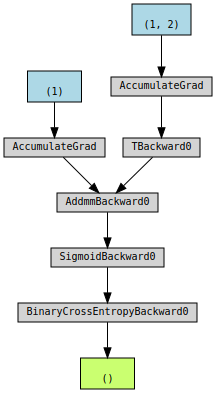

In [21]:
# 予測計算
outputs = net(inputs)

# 損失計算
loss = criterion(outputs, labels1)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [58]:
# 学習率
lr = 0.01

# 初期化
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net(n_input, n_output).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.BCELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 記録用リストの初期化
history = np.zeros((0,5))

In [62]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels1)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    # 損失の保存(スカラー値の取得)
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.5, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels1_test)

    # 損失の保存（スカラー値の取得）
    val_loss =  loss_test.item()
        
    # 予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    
    if ( epoch % 100 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 0.03816 acc: 1.00000 val_loss: 0.12000, val_acc: 0.96667
Epoch [100/10000], loss: 0.03808 acc: 1.00000 val_loss: 0.11997, val_acc: 0.96667
Epoch [200/10000], loss: 0.03800 acc: 1.00000 val_loss: 0.11994, val_acc: 0.96667
Epoch [300/10000], loss: 0.03791 acc: 1.00000 val_loss: 0.11992, val_acc: 0.96667
Epoch [400/10000], loss: 0.03783 acc: 1.00000 val_loss: 0.11989, val_acc: 0.96667
Epoch [500/10000], loss: 0.03776 acc: 1.00000 val_loss: 0.11987, val_acc: 0.96667
Epoch [600/10000], loss: 0.03768 acc: 1.00000 val_loss: 0.11985, val_acc: 0.96667
Epoch [700/10000], loss: 0.03760 acc: 1.00000 val_loss: 0.11982, val_acc: 0.96667
Epoch [800/10000], loss: 0.03752 acc: 1.00000 val_loss: 0.11980, val_acc: 0.96667
Epoch [900/10000], loss: 0.03744 acc: 1.00000 val_loss: 0.11977, val_acc: 0.96667
Epoch [1000/10000], loss: 0.03736 acc: 1.00000 val_loss: 0.11975, val_acc: 0.96667
Epoch [1100/10000], loss: 0.03729 acc: 1.00000 val_loss: 0.11973, val_acc: 0.96667
Epoch [1200/1000

In [25]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 0.63002 精度: 0.50000
最終状態: 損失: 0.63002 精度: 0.50000


In [ ]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [ ]:
# 検証データを散布図用に準備

x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

In [ ]:
# パラメータの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

In [ ]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()